# Asset Price Prediction

![Project Image](price_prediction.jpg)

## Outline

<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#preprocessing">Pre-Processing</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#splitting">Data Splitting</a></li>
<li><a href="#modelling">Modelling</a></li>
<li><a href="#conclusion">Conclusion</a></li>
</ul>

<a id='intro'></a>
# Introduction

This notebook presents a Long Short Term Model (LSTM) recurrent neural network designed to predict the price direction of an asset, utilizing a prediction window of 30 minutes. The objective of this project is to leverage available data and develop a robust predictive model.

By thoroughly documenting each step and providing clear explanations of the decisions made throughout the modeling process, this notebook aims to demonstrate a deep understanding of deep learning principles and their application to financial price prediction. The insights gained from this project can inform future work in asset price forecasting and contribute to more effective decision-making in financial markets.

### Dataset Description

- **open**: The price of the asset at the beginning of the trading period

- **high**: The highest price of the asset reached during the trading period

- **low**: The lowest price of the asset reached during the trading period

- **close**: The price of the asset at the end of the trading period

- **volume**: The total number of units of the asset traded during the trading period

- **nb_trades**: The total number of trades or transactions involving the asset during the trading period

- **buy_base_vol**: The total volume of buy orders executed for the asset during the trading period

<a id='preprocessing'></a>
# Pre-Processing

In [1]:
# pip install tensorflow

In [2]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [3]:
# load dataset into pandas dataframe and view first few lines of the data

df = pd.read_csv('asset_data.csv')
df.head()

,utc_date,open,high,low,close,volume,nb_trades,buy_base_vol
0,2023-01-01 00:00:00,0.07017,0.07025,0.07025,0.07025,453751,47,452366
1,2023-01-01 00:00:30,0.07025,0.07026,0.07026,0.07026,10304,6,9900
2,2023-01-01 00:01:00,0.07026,0.07033,0.07032,0.07032,130672,39,47509
3,2023-01-01 00:01:30,0.07032,0.07034,0.07034,0.07031,225147,33,7090
4,2023-01-01 00:02:00,0.07031,0.07034,0.07034,0.07033,133506,16,39598


In [4]:
# view the info of the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434880 entries, 0 to 434879
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   utc_date      434880 non-null  object 
 1   open          434880 non-null  float64
 2   high          434880 non-null  float64
 3   low           434880 non-null  float64
 4   close         434880 non-null  float64
 5   volume        434880 non-null  int64  
 6   nb_trades     434880 non-null  int64  
 7   buy_base_vol  434880 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 26.5+ MB


In [5]:
# Convert dates datatype to datetime

df['utc_date'] = pd.to_datetime(df['utc_date'])

In [6]:
# confirm datatype change

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434880 entries, 0 to 434879
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   utc_date      434880 non-null  datetime64[ns]
 1   open          434880 non-null  float64       
 2   high          434880 non-null  float64       
 3   low           434880 non-null  float64       
 4   close         434880 non-null  float64       
 5   volume        434880 non-null  int64         
 6   nb_trades     434880 non-null  int64         
 7   buy_base_vol  434880 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 26.5 MB


In [7]:
# set date column to index

df.set_index('utc_date',inplace=True)

In [8]:
# resample data from seconds format into minutes format

df = df.resample("1T").mean()
df

,open,high,low,close,volume,nb_trades,buy_base_vol
utc_date,,,,,,,
2023-01-01 00:00:00,0.070210,0.070255,0.070255,0.070255,232027.5,26.5,231133.0
2023-01-01 00:01:00,0.070290,0.070335,0.070330,0.070315,177909.5,36.0,27299.5
2023-01-01 00:02:00,0.070320,0.070335,0.070335,0.070325,74564.0,11.5,20474.0
2023-01-01 00:03:00,0.070280,0.070280,0.070280,0.070220,251636.5,24.0,7587.0
2023-01-01 00:04:00,0.070190,0.070190,0.070190,0.070175,48985.0,12.5,38666.5
...,...,...,...,...,...,...,...
2023-05-31 23:55:00,0.071650,0.071650,0.071650,0.071650,37263.5,3.0,34586.5
2023-05-31 23:56:00,0.071655,0.071660,0.071660,0.071660,70228.0,13.0,69646.0
2023-05-31 23:57:00,0.071655,0.071655,0.071655,0.071650,12197.5,5.5,8422.5


In [9]:
# view the statistics of the dataset

df.describe()

,open,high,low,close,volume,nb_trades,buy_base_vol
count,217440.000000,217440.000000,217440.000000,217440.000000,2.174400e+05,217440.000000,2.174400e+05
mean,0.079869,0.079898,0.079894,0.079869,4.229901e+05,72.738670,2.080826e+05
std,0.007297,0.007307,0.007305,0.007297,1.143462e+06,195.892042,5.766245e+05
min,0.062675,0.062860,0.062850,0.062765,0.000000e+00,0.000000,0.000000e+00
25%,0.073390,0.073410,0.073405,0.073390,7.834575e+04,18.500000,2.839738e+04
50%,0.079290,0.079310,0.079310,0.079290,1.761192e+05,35.000000,8.177875e+04
75%,0.085595,0.085630,0.085625,0.085596,3.886338e+05,69.000000,1.944065e+05
max,0.103400,0.104530,0.103820,0.103470,6.836507e+07,14626.000000,3.792912e+07


The statistical summary indicates similar distributions among the open, high, low, and close price features, all centered around a mean value of approximately 0.07987, with low variability as indicated by their standard deviations around 0.0073. This suggests a relatively stable asset price within the observed period.

The volume and buy_base_vol features exhibit significant variability, as highlighted by their high standard deviations, which indicates a wide range of trading activities and buying volumes. Both metrics have extreme maximum values, suggesting occasional periods of unusually high activity.

The nb_trades feature has a high standard deviation of 195.89 compared to its mean of 72.74, indicating that the number of trades is highly spread out around the mean. This dispersion suggests variability in trading frequency, with some periods experiencing significantly more trades than others.

Overall, the data reflects stable asset prices but variable trading volumes and activities, with notable outliers in trading volume and number of trades.

### Predictions will be done on the close column, due to its relevance in financial decision-making, its role in capturing the end-of-day market consensus, and its standard use in predictive modeling. This approach aligns with common practices in financial forecasting and provides a meaningful basis for evaluating trading strategies and market behavior.

In [10]:
# split data into predictor and target variables before scaling

X = df.drop(['close'], axis = 1)
y = df['close']

In [11]:
X

,open,high,low,volume,nb_trades,buy_base_vol
utc_date,,,,,,
2023-01-01 00:00:00,0.070210,0.070255,0.070255,232027.5,26.5,231133.0
2023-01-01 00:01:00,0.070290,0.070335,0.070330,177909.5,36.0,27299.5
2023-01-01 00:02:00,0.070320,0.070335,0.070335,74564.0,11.5,20474.0
2023-01-01 00:03:00,0.070280,0.070280,0.070280,251636.5,24.0,7587.0
2023-01-01 00:04:00,0.070190,0.070190,0.070190,48985.0,12.5,38666.5
...,...,...,...,...,...,...
2023-05-31 23:55:00,0.071650,0.071650,0.071650,37263.5,3.0,34586.5
2023-05-31 23:56:00,0.071655,0.071660,0.071660,70228.0,13.0,69646.0
2023-05-31 23:57:00,0.071655,0.071655,0.071655,12197.5,5.5,8422.5


In [12]:
# scale predictor features to improve uniformity

mm = MinMaxScaler()
X_mm = mm.fit_transform(X)

In [13]:
X_mm

array([[1.85021486e-01, 1.77465803e-01, 1.80742006e-01, 3.39394823e-03,
        1.81184193e-03, 6.09381458e-03],
       [1.86985881e-01, 1.79385649e-01, 1.82572614e-01, 2.60234512e-03,
        2.46137016e-03, 7.19750495e-04],
       [1.87722529e-01, 1.79385649e-01, 1.82694655e-01, 1.09067398e-03,
        7.86271024e-04, 5.39796393e-04],
       ...,
       [2.20503376e-01, 2.11063115e-01, 2.14913351e-01, 1.78417143e-04,
        3.76042664e-04, 2.22058959e-04],
       [2.20380602e-01, 2.10943125e-01, 2.14791311e-01, 3.18320464e-04,
        2.39299877e-04, 5.30805938e-04],
       [2.20503376e-01, 2.11183105e-01, 2.15035392e-01, 4.60439829e-04,
        5.12785451e-04, 3.45196550e-04]])

In [14]:
# convert scaled predictor features and target variable back into a dataframe

df_Xy = pd.DataFrame(columns = X.columns, 
                     data = X_mm, index = df.index)

df_Xy['close'] = y

In [15]:
df_Xy

,open,high,low,volume,nb_trades,buy_base_vol,close
utc_date,,,,,,,
2023-01-01 00:00:00,0.185021,0.177466,0.180742,0.003394,0.001812,0.006094,0.070255
2023-01-01 00:01:00,0.186986,0.179386,0.182573,0.002602,0.002461,0.000720,0.070315
2023-01-01 00:02:00,0.187723,0.179386,0.182695,0.001091,0.000786,0.000540,0.070325
2023-01-01 00:03:00,0.186740,0.178066,0.181352,0.003681,0.001641,0.000200,0.070220
2023-01-01 00:04:00,0.184530,0.175906,0.179155,0.000717,0.000855,0.001019,0.070175
...,...,...,...,...,...,...,...
2023-05-31 23:55:00,0.220381,0.210943,0.214791,0.000545,0.000205,0.000912,0.071650
2023-05-31 23:56:00,0.220503,0.211183,0.215035,0.001027,0.000889,0.001836,0.071660
2023-05-31 23:57:00,0.220503,0.211063,0.214913,0.000178,0.000376,0.000222,0.071650


<a id='eda'></a>
# Exploratory Data Analysis

#### Explore the distribution of the high, low and open features against the distribution of the close feature

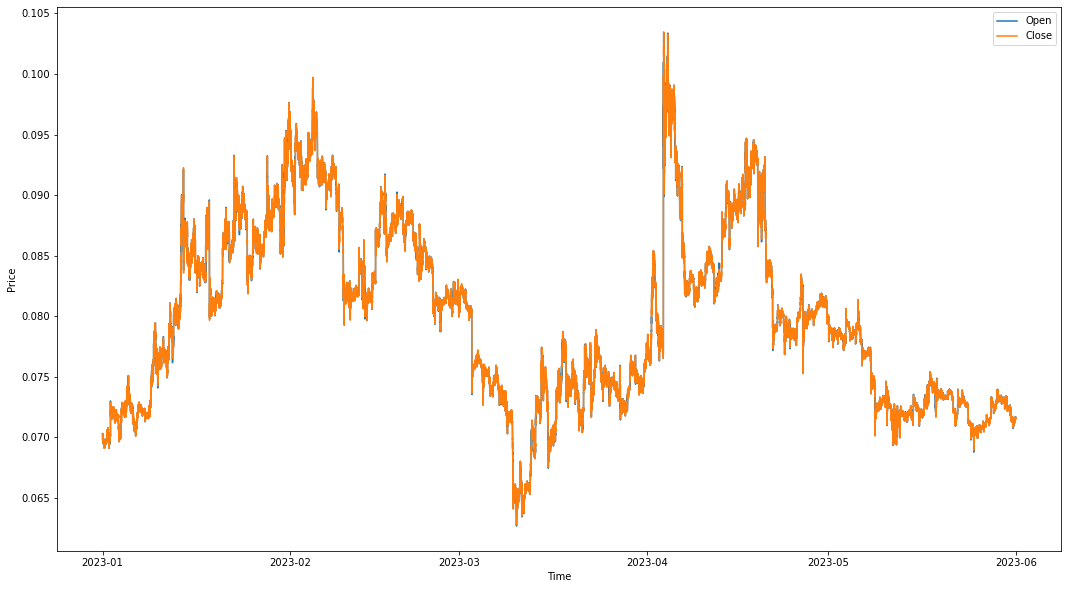

In [16]:
# plot a line chart to compare the movement of the open and close features

plt.figure(figsize = (18,10))

plt.plot(df.index, df['open'], label = 'Open')
plt.plot(df.index, df['close'], label = 'Close')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

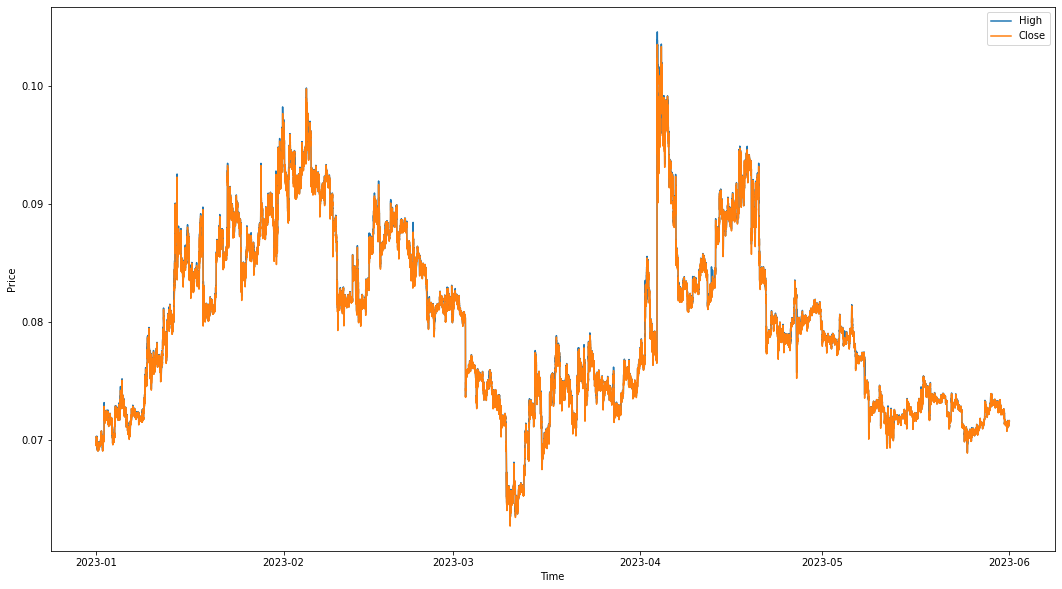

In [17]:
# plot a line chart to compare the movement of the high and close features

plt.figure(figsize = (18,10))

plt.plot(df.index, df['high'], label = 'High')
plt.plot(df.index, df['close'], label = 'Close')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

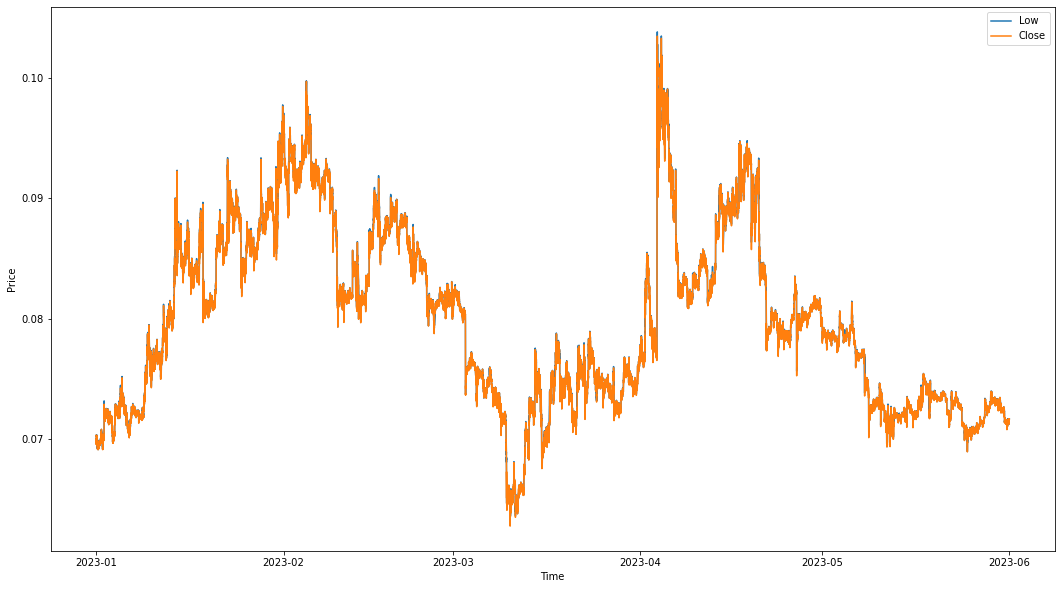

In [18]:
# plot a line chart to compare the movement of the low and close features

plt.figure(figsize = (18,10))

plt.plot(df.index, df['low'], label = 'Low')
plt.plot(df.index, df['close'], label = 'Close')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

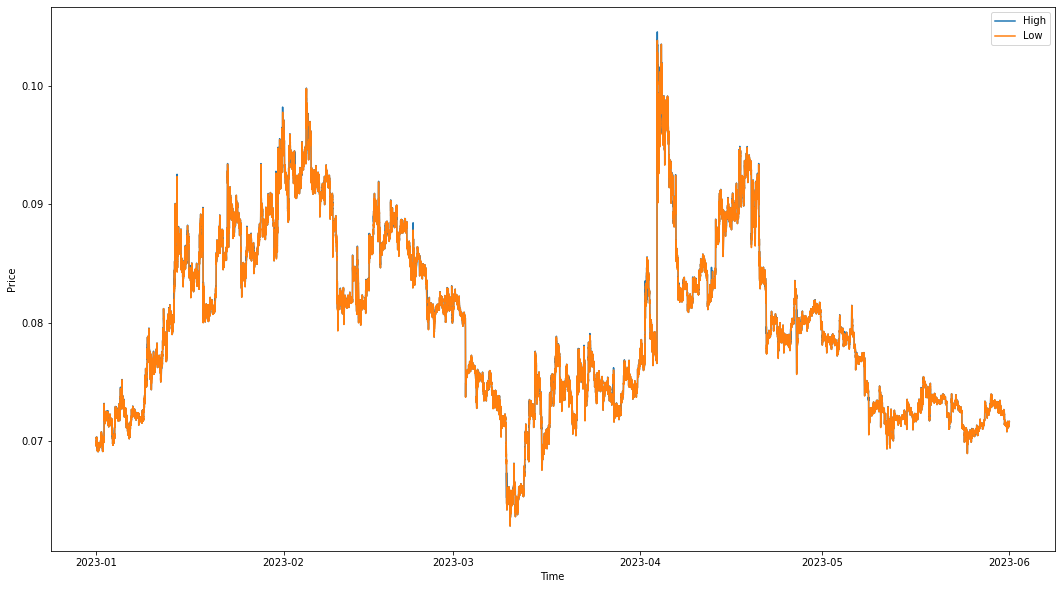

In [19]:
# plot a line chart to compare the movement of the high and low features

plt.figure(figsize = (18,10))

plt.plot(df.index, df['high'], label = 'High')
plt.plot(df.index, df['low'], label = 'Low')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

On a high level, there are negligible differences between the high, low, open and close features across the months, with generally peak prices in the beginning of February and most of April, while the beginning of January, middle of March and the entire May had the lowest prices

Due to the huge amount of data, it might be helpful to view the distributions of the prices on a daily basis to observe if there were any major exceptions from the distributions by minutes plotted above.

In [20]:
# resample data to daily format for plotting purpose

df_daily = df.resample("D").mean()
df_daily

,open,high,low,close,volume,nb_trades,buy_base_vol
utc_date,,,,,,,
2023-01-01,0.069787,0.069801,0.069800,0.069787,155015.526042,21.972222,78172.171875
2023-01-02,0.071348,0.071367,0.071365,0.071349,387280.326736,45.924306,200746.185069
2023-01-03,0.071095,0.071111,0.071110,0.071095,254488.438889,33.438889,121181.531250
2023-01-04,0.072130,0.072153,0.072151,0.072131,274400.936806,43.935417,138412.863889
2023-01-05,0.072996,0.073018,0.073016,0.072995,417259.180556,52.320139,207551.947917
...,...,...,...,...,...,...,...
2023-05-27,0.071497,0.071507,0.071506,0.071498,128025.259028,20.936111,66435.231250
2023-05-28,0.072729,0.072741,0.072740,0.072730,151154.327083,24.477083,76429.719444
2023-05-29,0.073243,0.073253,0.073252,0.073242,107737.581944,17.520139,55195.125000


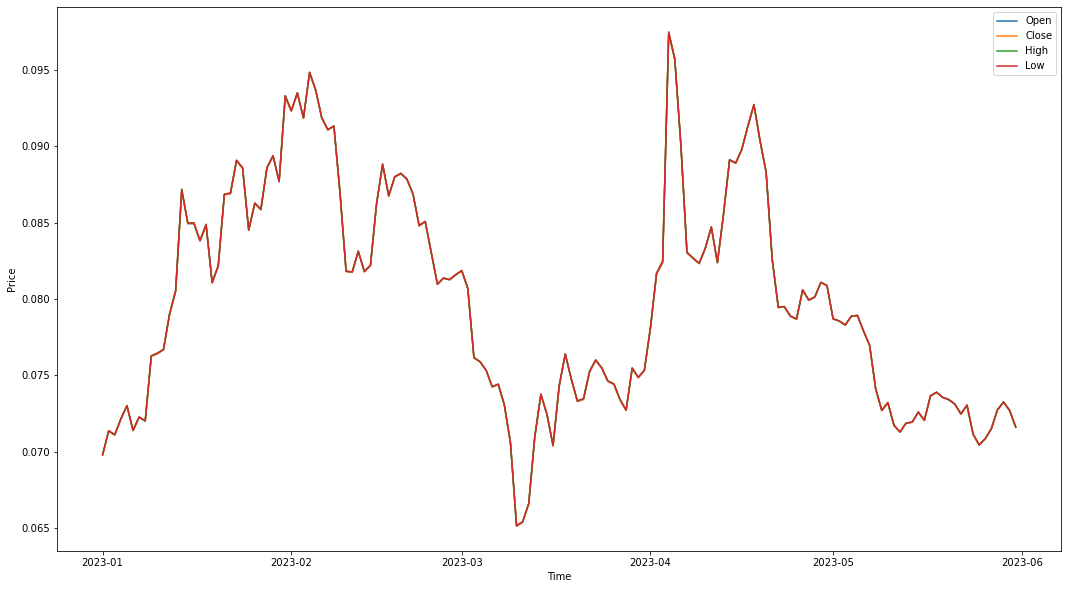

In [21]:
# plot a line chart to compare the movement of high, low, open and close features

plt.figure(figsize = (18,10))

plt.plot(df_daily.index, df_daily['open'], label = 'Open')
plt.plot(df_daily.index, df_daily['close'], label = 'Close')
plt.plot(df_daily.index, df_daily['high'], label = 'High')
plt.plot(df_daily.index, df_daily['low'], label = 'Low')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

> On a daily basis, there were very negligible differences between the high, low, open and close features across the months, with similar distributions as the earlier minute based plots 

<a id='splitting'></a>
# Data Splitting

> Define a function to split the data into target and predictor variables based on specified window of number of input steps required to make the specified number of output predictions

> Apply function to data and split further into train and test sets

In [22]:
# create function to split into reformed target and predictor variables based on specified input and output numbers 

def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
    # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# choose a number of time steps and apply splitting function

n_steps_in, n_steps_out = 30, 30

X1, y1 = split_sequences(df_Xy.values, n_steps_in, n_steps_out)

In [23]:
print(X1[0])
print(y1[0])

[[1.85021486e-01 1.77465803e-01 1.80742006e-01 3.39394823e-03
  1.81184193e-03 6.09381458e-03]
 [1.86985881e-01 1.79385649e-01 1.82572614e-01 2.60234512e-03
  2.46137016e-03 7.19750495e-04]
 [1.87722529e-01 1.79385649e-01 1.82694655e-01 1.09067398e-03
  7.86271024e-04 5.39796393e-04]
 [1.86740331e-01 1.78065755e-01 1.81352209e-01 3.68077600e-03
  1.64091344e-03 2.00031026e-04]
 [1.84530387e-01 1.75905928e-01 1.79155480e-01 7.16520904e-04
  8.54642418e-04 1.01944111e-03]
 [1.84407612e-01 1.76145908e-01 1.79399561e-01 1.27661104e-02
  5.81156844e-03 1.08110613e-02]
 [1.84407612e-01 1.76265899e-01 1.79521601e-01 1.93712235e-03
  9.23013811e-04 6.38085000e-04]
 [1.84162063e-01 1.75665947e-01 1.78911399e-01 5.16704675e-03
  2.42718447e-03 1.94580069e-03]
 [1.83057090e-01 1.74466043e-01 1.77690993e-01 2.01657082e-03
  1.43579926e-03 2.01751341e-03]
 [1.81338244e-01 1.73026158e-01 1.76226507e-01 7.83740907e-04
  1.09394229e-03 7.18458611e-04]
 [1.80724371e-01 1.73026158e-01 1.76226507e-01 4.4

In [24]:
# split reformed target and predictor variables into train and test sets using chosen train_split

train_split = 0.75
split_idx = int(len(X1)*train_split)

X_train, X_test = X1[:split_idx], X1[split_idx: ]
y_train, y_test = y1[:split_idx], y1[split_idx: ]

print (X1.shape, y1.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(217382, 30, 6) (217382, 30) (163036, 30, 6) (54346, 30, 6) (163036, 30) (54346, 30)


<a id='modelling'></a>
# Modelling

> Multivariate Vector Output and Encoder-Decoder LSTM models will be built. Performances will be compared and the preferable model will be selected

### Vector Ouput LSTM Model

In [25]:
# build model

lstm = Sequential()
lstm.add(LSTM(50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu'))
lstm.add(LSTM(50, return_sequences = True))
lstm.add(LSTM(50))
lstm.add(Dense(n_steps_out))
lstm.compile(loss = 'mean_squared_error', optimizer = 'adam')
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            11400     
                                                                 
 lstm_1 (LSTM)               (None, 30, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 30)                1530      
                                                                 
Total params: 53330 (208.32 KB)
Trainable params: 53330 (208.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
# train model

history = lstm.fit(X_train, y_train, epochs = 100, batch_size = 64)

Epoch 1/100
2548/2548 [==============================] - 124s 47ms/step - loss: 1.2922e-05
Epoch 2/100
2548/2548 [==============================] - 137s 54ms/step - loss: 3.5738e-07
Epoch 3/100
2548/2548 [==============================] - 130s 51ms/step - loss: 3.2544e-07
Epoch 4/100
2548/2548 [==============================] - 101s 40ms/step - loss: 2.9464e-07
Epoch 5/100
2548/2548 [==============================] - 116s 45ms/step - loss: 2.6590e-07
Epoch 6/100
2548/2548 [==============================] - 138s 54ms/step - loss: 2.5344e-07
Epoch 7/100
2548/2548 [==============================] - 129s 51ms/step - loss: 2.4167e-07
Epoch 8/100
2548/2548 [==============================] - 110s 43ms/step - loss: 2.2588e-07
Epoch 9/100
2548/2548 [==============================] - 115s 45ms/step - loss: 2.1650e-07
Epoch 10/100
2548/2548 [==============================] - 124s 49ms/step - loss: 2.1604e-07
Epoch 11/100
2548/2548 [==============================] - 111s 44ms/step - loss: 2.0739e-

In [27]:
# make predictions

y_pred = lstm.predict(X_test)

1699/1699 [==============================] - 23s 13ms/step


In [28]:
y_pred

array([[0.0790409 , 0.07914941, 0.07917723, ..., 0.07924607, 0.07918379,
        0.07910979],
       [0.07904694, 0.07915622, 0.07918331, ..., 0.07925349, 0.07919102,
        0.07911714],
       [0.07902687, 0.07913529, 0.07916226, ..., 0.07923177, 0.07917036,
        0.07909563],
       ...,
       [0.0715184 , 0.07164019, 0.07168504, ..., 0.07169546, 0.07162754,
        0.07156731],
       [0.07152909, 0.07165088, 0.07169617, ..., 0.07170589, 0.07163844,
        0.07157789],
       [0.07155027, 0.07167235, 0.07171804, ..., 0.07172757, 0.07166017,
        0.07159973]], dtype=float32)

In [37]:
# evaluate metrics

mse = mean_squared_error(y_test, y_pred, squared = False)
mape = mean_absolute_percentage_error(y_test, y_pred)

print('MSE: ', f'{rmse:.9f}')
print('MAPE: ', f'{mape:.9f}')

MSE:  0.000192746
MAPE:  0.001674762


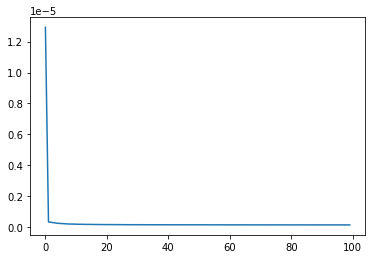

In [30]:
# plot loss movement across epochs

plt.plot((history.history['loss']))
plt.show()

> The plot above shows a significant decrease in loss from the start up to around 5 epochs, followed by a period of relatively stable loss with minimal changes in the subsequent epochs

### Encoder-Decoder Model

In [31]:
# build model

lstm_2 = Sequential()
lstm_2.add(LSTM(50, input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu'))
lstm_2.add(RepeatVector(n_steps_out))
lstm_2.add(LSTM(50, return_sequences = True))
lstm_2.add(TimeDistributed(Dense(1)))
lstm_2.compile(loss = 'mean_squared_error', optimizer = 'adam')
lstm_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                11400     
                                                                 
 repeat_vector (RepeatVecto  (None, 30, 50)            0         
 r)                                                              
                                                                 
 lstm_4 (LSTM)               (None, 30, 50)            20200     
                                                                 
 time_distributed (TimeDist  (None, 30, 1)             51        
 ributed)                                                        
                                                                 
Total params: 31651 (123.64 KB)
Trainable params: 31651 (123.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
# train model

history_2 = lstm_2.fit(X_train, y_train, epochs = 100, batch_size = 64)

Epoch 1/100
2548/2548 [==============================] - 77s 29ms/step - loss: 1.4898e-05
Epoch 2/100
2548/2548 [==============================] - 69s 27ms/step - loss: 4.0958e-07
Epoch 3/100
2548/2548 [==============================] - 69s 27ms/step - loss: 3.6197e-07
Epoch 4/100
2548/2548 [==============================] - 74s 29ms/step - loss: 2.7497e-07
Epoch 5/100
2548/2548 [==============================] - 70s 28ms/step - loss: 2.4061e-07
Epoch 6/100
2548/2548 [==============================] - 71s 28ms/step - loss: 2.1913e-07
Epoch 7/100
2548/2548 [==============================] - 71s 28ms/step - loss: 2.1074e-07
Epoch 8/100
2548/2548 [==============================] - 71s 28ms/step - loss: 2.0639e-07
Epoch 9/100
2548/2548 [==============================] - 72s 28ms/step - loss: 1.9608e-07
Epoch 10/100
2548/2548 [==============================] - 73s 29ms/step - loss: 1.9339e-07
Epoch 11/100
2548/2548 [==============================] - 74s 29ms/step - loss: 1.8958e-07
Epoch 12

In [33]:
# make predictions

y_pred_2 = lstm_2.predict(X_test)

1699/1699 [==============================] - 16s 9ms/step


In [34]:
y_pred_2

array([[[0.07903893],
        [0.07906321],
        [0.07906356],
        ...,
        [0.0790706 ],
        [0.07907061],
        [0.07907061]],

       [[0.07904647],
        [0.07907038],
        [0.07907059],
        ...,
        [0.07907784],
        [0.07907785],
        [0.07907785]],

       [[0.07902752],
        [0.07905136],
        [0.07905156],
        ...,
        [0.07905877],
        [0.07905878],
        [0.07905879]],

       ...,

       [[0.07162214],
        [0.07158078],
        [0.07159497],
        ...,
        [0.07161122],
        [0.07161123],
        [0.07161125]],

       [[0.07163372],
        [0.07159244],
        [0.07160659],
        ...,
        [0.07162287],
        [0.07162289],
        [0.0716229 ]],

       [[0.07165208],
        [0.07161111],
        [0.07162525],
        ...,
        [0.07164147],
        [0.07164149],
        [0.0716415 ]]], dtype=float32)

In [38]:
# evaluate metrics

y_pred_2 = np.reshape(y_pred_2, (y_pred_2.shape[0], y_pred_2.shape[1]))

mse_2 = mean_squared_error(y_test, y_pred_2, squared = False)
mape_2 = mean_absolute_percentage_error(y_test, y_pred_2)

print('MSE: ', f'{rmse_2:.9f}')
print('MAPE: ', f'{mape_2:.9f}')

MSE:  0.000178391
MAPE:  0.001463958


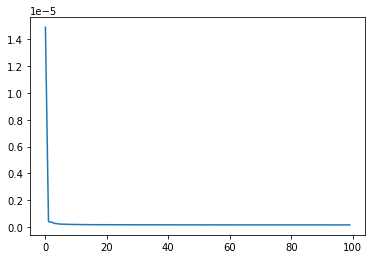

In [39]:
# plot loss movement across epochs

plt.plot((history_2.history['loss']))
plt.show()

> The Encoder-Decoder plot also shows a significant decrease in loss similar to the Vector Output, from the start up to around 5 epochs, followed by a period of relatively stable loss with minimal changes in the subsequent epochs

<a id='conclusion'></a>
# Conclusion

The two models generally predict the trend of the actual prices very closely. However, the Encoder-Decoder model outperformed the Vector Output model in both key metrics of mean squared error and mean absolute percentage error. 

Since the primary metric being considered is the mean squared error, the Encoder-Decoder model is the preferred choice due to its lower value, indicating higher accuracy in predicting the closing prices.